# **Housing Prices Competition**

## Contents:
1. **[X, y Summary](#DF)**
    * Import Libraries
    * Read the data
    * X, y info
    * Correlation between features and target on heatmap
2. **[Data Cleaning](#Clean)**
    * Remove the columns with more than half missing values
    * Drop columns with most of the rows having only one category
3. **[Feature Engineering](#Feature)**
    * Create New Numerical Features
    * Create New Boolean Features
    * Replace ordered categories with numbers
    * Create features using mathematical transformations
    * Create feature using count
    * Create feature using group transforms
    * Drop high cordinality categorical columns
    * Handle rare categorical values
    * Create features using feature interactions
    * Impute numerical columns
4. **[Data Visualization](#Viz)**
    * Distribution of top 5 features correlated with Sales Price
5. **[Feature Selection](#Select)**
    * Selecte Features
6. **[Model Creation](#Model)**
    * Grid Search
7. **[Training and Testing Model](#Test)**
    * Best Parameters
    * Feature Importance

# 1) X, y Summary<a id="DF"></a>

## Import Libraries

In [1]:
# Data Analytics Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype

# Machine Learning Libraries
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder #LabelEncoder #OneHotEncoder
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
from math import ceil

# Update some default parameters for plotting throughout the notebook
plt.rcParams.update({'font.size': 12, 'xtick.labelsize':15, 'ytick.labelsize':15, 'axes.labelsize':15, 'axes.titlesize':20})

## Create X, y DataFrames

In [2]:
# Read the data
df_train = pd.read_csv('train.csv', index_col='Id')
df_test = pd.read_csv('test.csv', index_col='Id')

# Remove rows with missing target
X_train = df_train.dropna(axis=0, subset=['SalePrice'])

# Separate target from predictors
X_train = df_train.drop(['SalePrice'], axis=1)
y_train = df_train.SalePrice
X_test = df_test

## X, y Info

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)

In [4]:
info = pd.DataFrame(X_train.dtypes, columns=['Dtype'])
info['Unique'] = X_train.nunique().values
info['Null'] = X_train.isnull().sum().values
info

,Dtype,Unique,Null
MSSubClass,int64,15,0
MSZoning,object,5,0
LotFrontage,float64,110,259
LotArea,int64,1073,0
Street,object,2,0
Alley,object,2,1369
LotShape,object,4,0
LandContour,object,4,0
Utilities,object,2,0
LotConfig,object,5,0


In [5]:
X_train.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

In [6]:
y_train.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: >

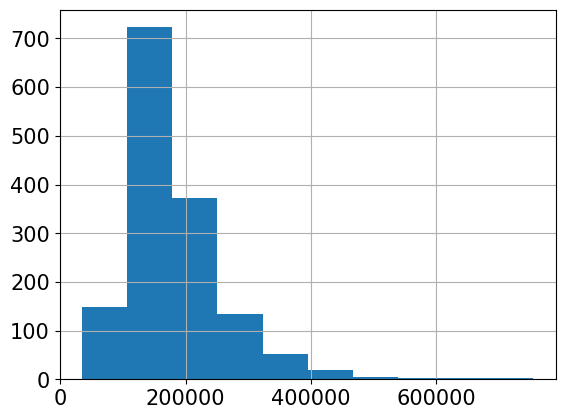

In [7]:
y_train.hist()

## Correlation between features and target on heatmap

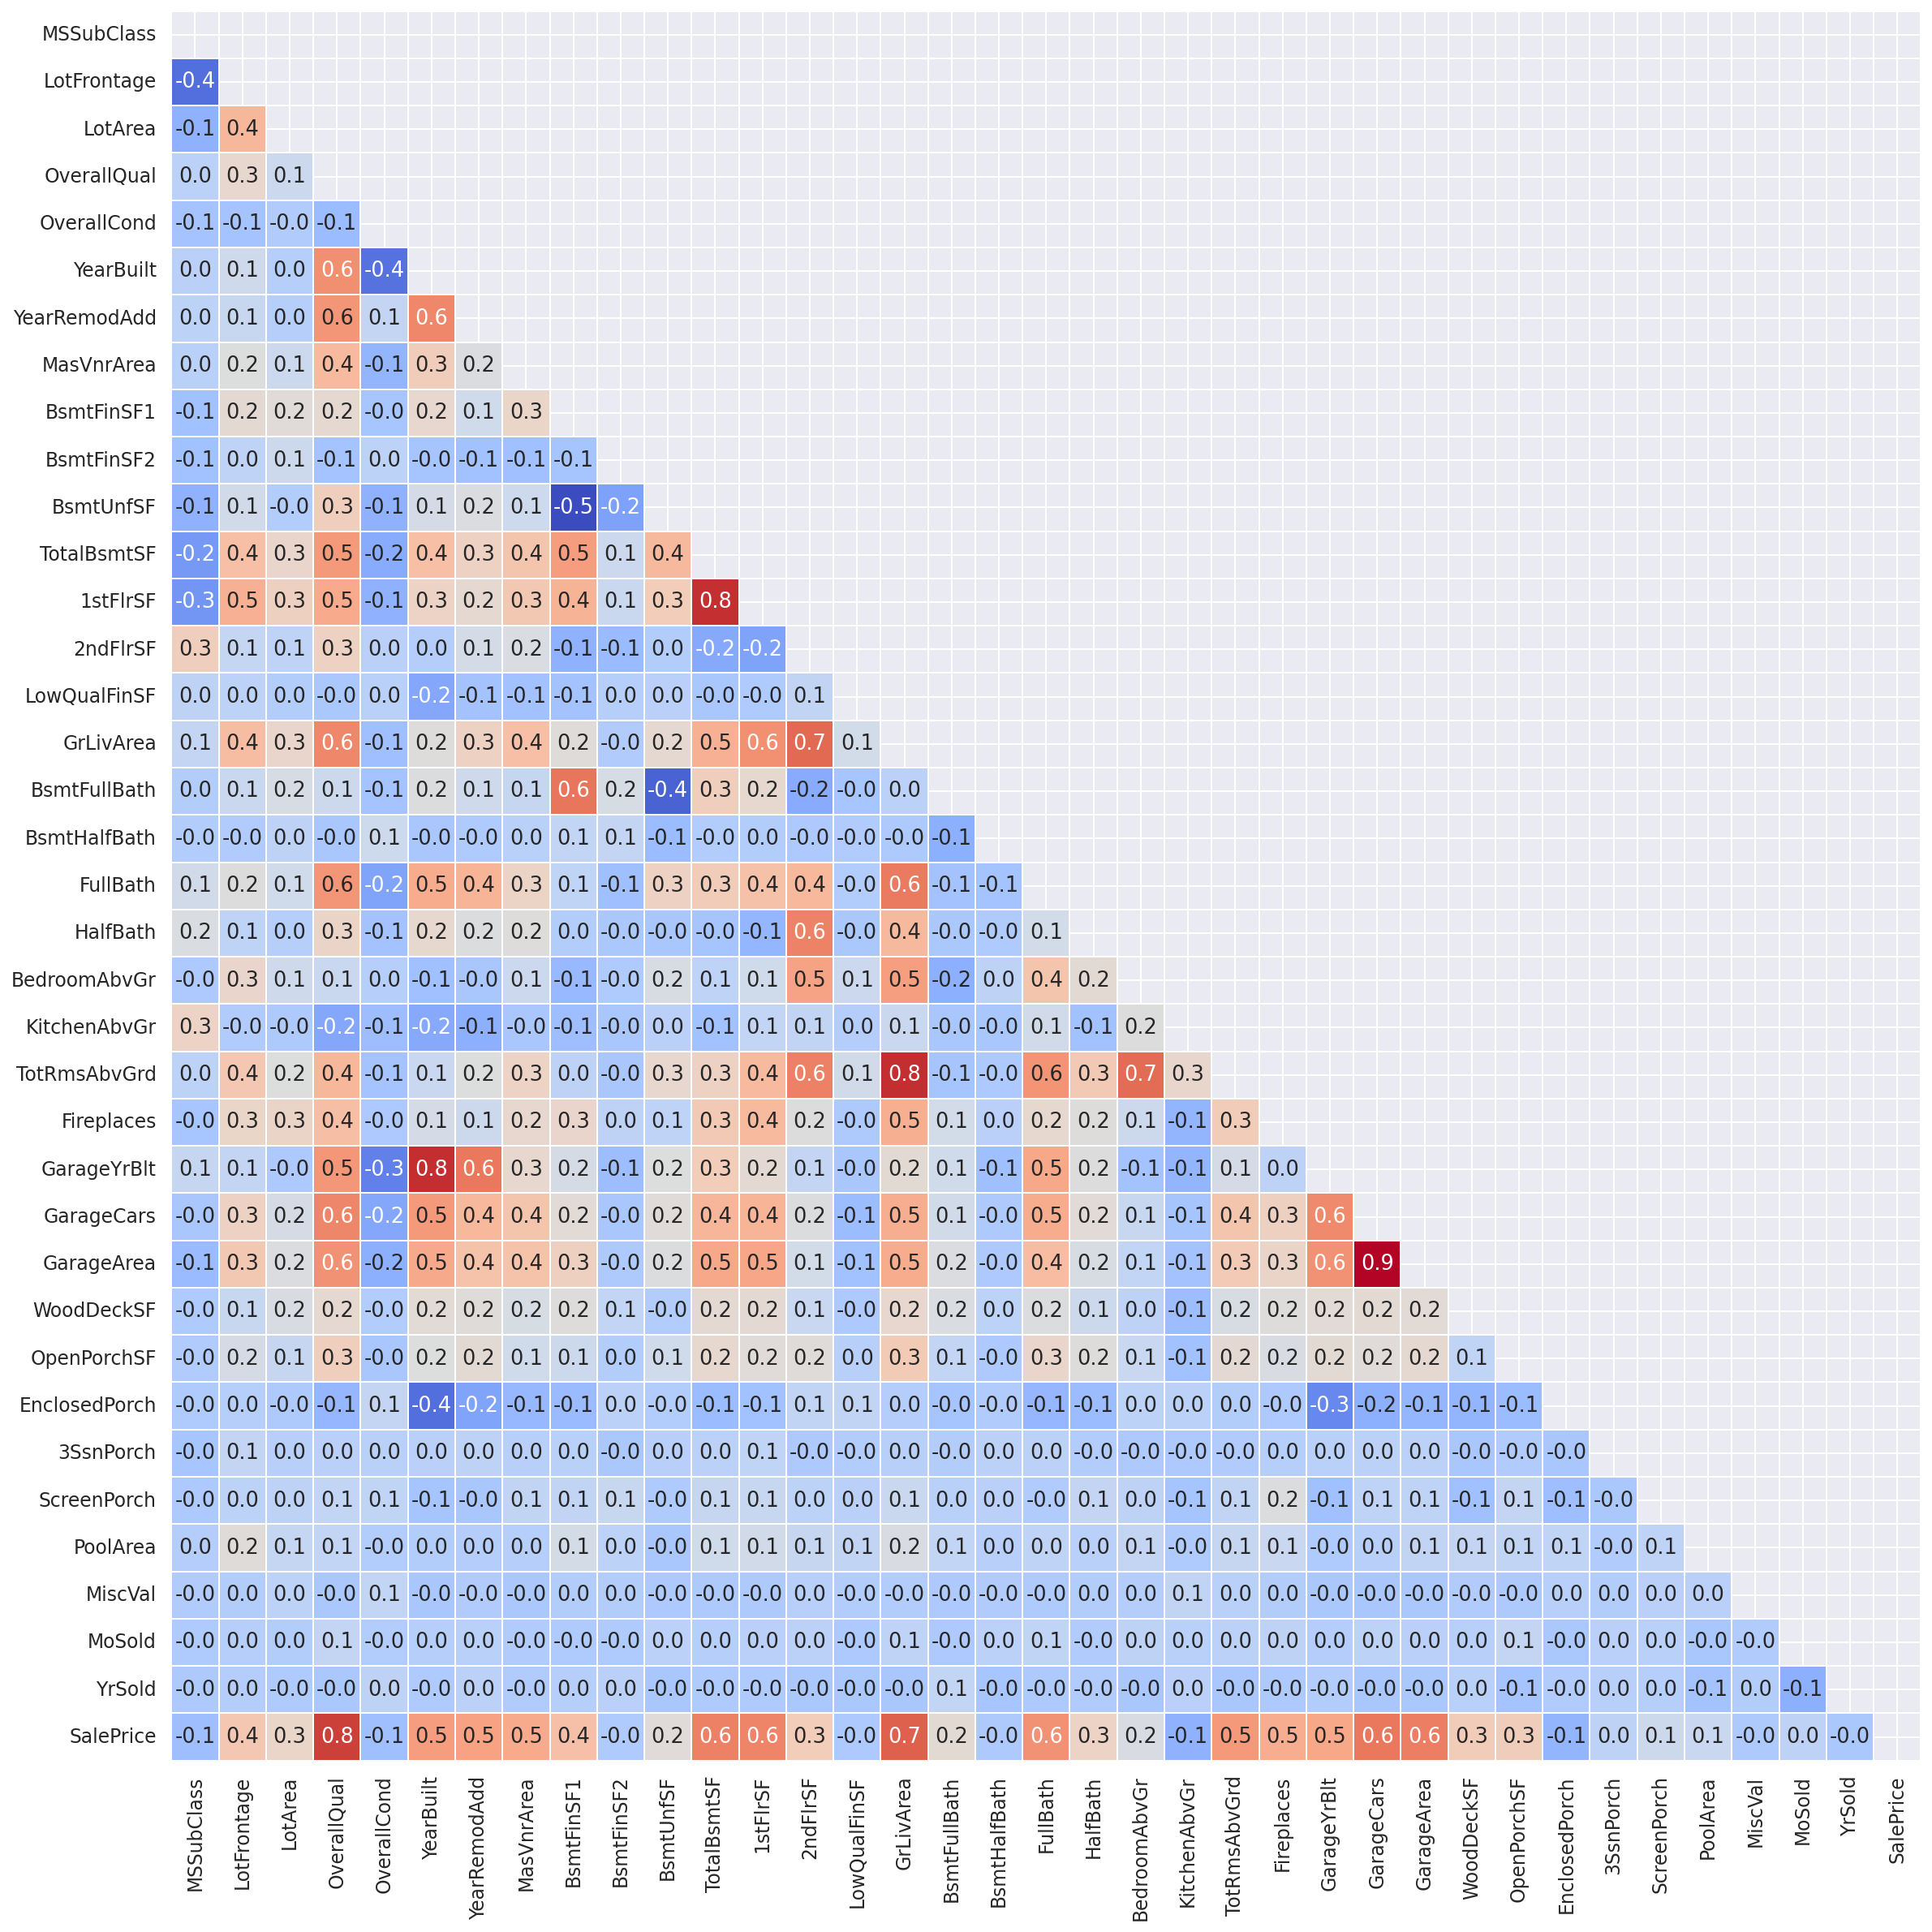

In [8]:
correlation_matrix = df_train.corr()

# Returns copy of array with upper part of the triangle (which will be masked/hidden)
mask = np.triu(correlation_matrix.corr())

sns.set(font_scale=1.1)
plt.figure(figsize=(20, 20), dpi=140)
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cmap='coolwarm', square=True, mask=mask, linewidths=1, cbar=False)
plt.show()

# 2) Data Cleaning<a id="Clean"></a>

In [9]:
# Total rows/observations/houses in Training data and Test data
print(len(X_train),len(X_test))

1460 1459


## Remove the columns with more than half missing values

In [10]:
# Making function so that we can reuse it in later stages as well
def show_null_values(X, X_test):
    # Missing values in each column of Training and Testing data
    null_values_train = X.isnull().sum()
    null_values_test = X_test.isnull().sum()

    # Making DataFrame for combining training and testing missing values
    null_values = pd.DataFrame(null_values_train)
    null_values['Test Data'] = null_values_test.values
    null_values.rename(columns = {0:'Train Data'}, inplace = True)

    # Showing only columns having missing values and sorting them
    null_values = null_values.loc[(null_values['Train Data']!=0) | (null_values['Test Data']!=0)]
    null_values = null_values.sort_values(by=['Train Data','Test Data'],ascending=False)
    
    print("Total missing values:",null_values.sum(),sep='\n')
    
    return null_values

In [11]:
show_null_values(X_train, X_test)

Total missing values:
Train Data    6965
Test Data     7000
dtype: int64


,Train Data,Test Data
PoolQC,1453,1456
MiscFeature,1406,1408
Alley,1369,1352
Fence,1179,1169
FireplaceQu,690,730
LotFrontage,259,227
GarageYrBlt,81,78
GarageFinish,81,78
GarageQual,81,78
GarageCond,81,78


In [12]:
# Columns with missing values in more than half number of rows
null_cols = [col for col in X_train.columns if X_train[col].isnull().sum() > len(X_train)/2]
null_cols

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [13]:
X_train.drop(null_cols,axis=1,inplace=True)
X_test.drop(null_cols,axis=1,inplace=True)

In [14]:
# Total missing values after removing columns with more than half missing values
print("Total missing values:")
print("Training data\t",X_train.isnull().sum().sum())
print("Testing data\t",X_test.isnull().sum().sum())

Total missing values:
Training data	 1558
Testing data	 1615


In [15]:
object_cols = X_train.select_dtypes('object').columns
len(object_cols)

39

# 3) Feature Engineering<a id="Feature"></a>

In [16]:
# Merge the datasets so we can process them together
df = pd.concat([X_train, X_test])

## 3.1) Creating New Numerical Features

In [17]:
df1 = pd.DataFrame()  # dataframe to hold new features

# Age of House when sold
df1['Age'] = df['YrSold']-df['YearBuilt']

# Years between Remodeling and sales
df1['AgeRemodel'] = df['YrSold']-df['YearRemodAdd']

Years = ['YrSold','YearBuilt','YearRemodAdd']
year_cols = ['YrSold','YearBuilt','AgeRemodel', 'Age']
df_1 = pd.concat([df, df1], axis=1).loc[:,year_cols]
X_1 = df_1.loc[X_train.index, :]
X_1.sample()

,YrSold,YearBuilt,AgeRemodel,Age
Id,,,,
233,2006,1972,34,34


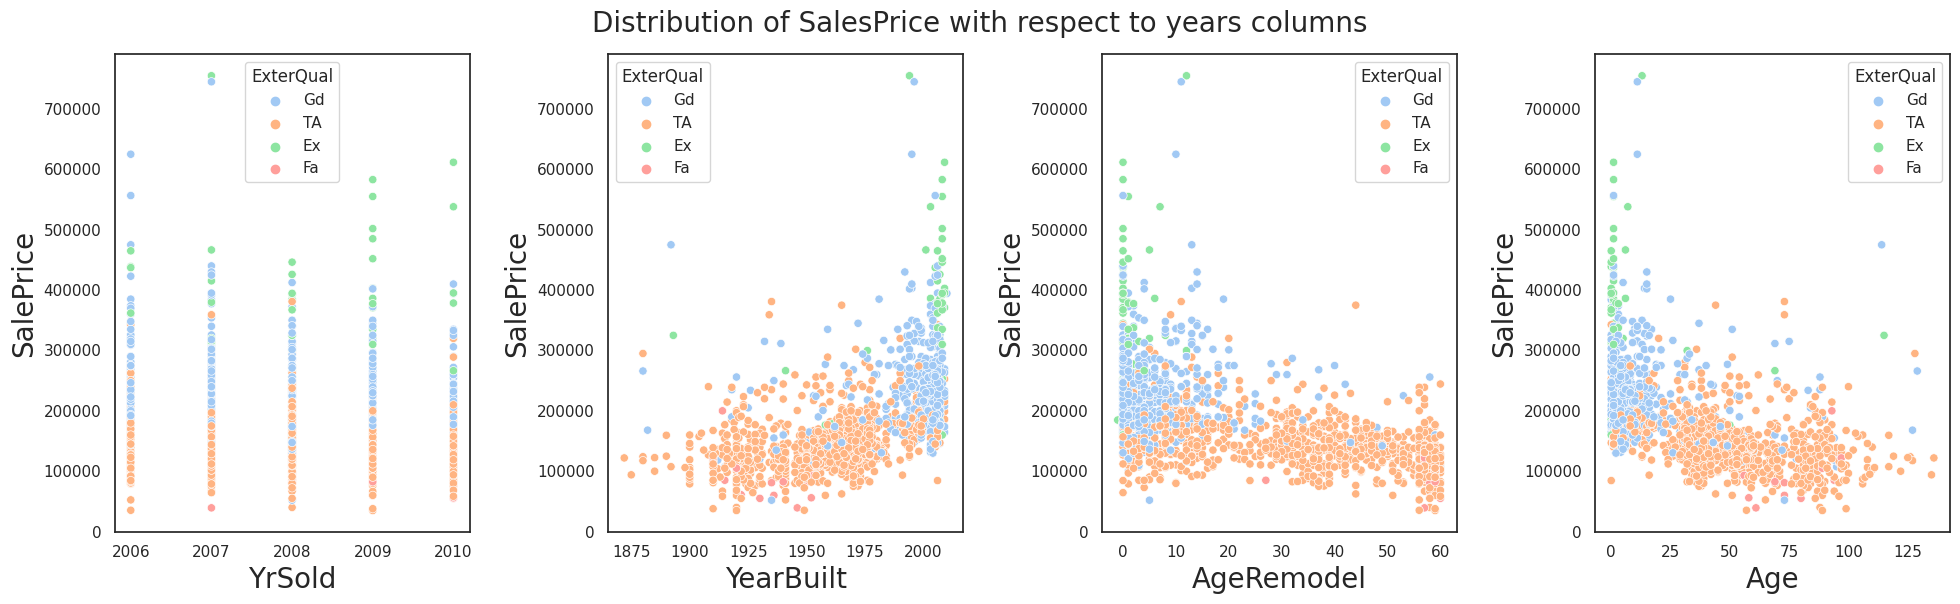

In [18]:
sns.set(style='whitegrid')
# sns.set_context("paper", rc={"font.size":20,"axes.titlesize":25,"axes.labelsize":20}) 
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")
# sns.set(font_scale=1.1)
fig, ax = plt.subplots(1, 4, figsize=(20, 6), dpi=100)

# scatterplot
for col,i in zip(year_cols, [0,1,2,3]):
    sns.scatterplot(x=X_1.loc[:,col], y=y_train, ax=ax[i], hue=X_train.ExterQual, palette='pastel')

fig.tight_layout()
fig.text(0.5, 1, 'Distribution of SalesPrice with respect to years columns', size=20, ha="center", va="center")
plt.show()

In [19]:
# Correlation of year columns with SalePrice
X_1.corrwith(y_train)

YrSold       -0.028923
YearBuilt     0.522897
AgeRemodel   -0.509079
Age          -0.523350
dtype: float64

## 3.2) Creating New Boolean Features
**Remodel column:**
* False (for 764 houses having Remodel date same as construction date i.e. no modeling or additions)
* True (for 696 houses with modeling or additions done)

**Garage column:**
* False (for 81 rows having missing values in columns GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond)

**Fireplace column:**
* False (for 690 rows having missing values in column FireplaceQu)

**Basement column:**
* False (for 37 rows having missing values in columns BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2)

**Masonry veneer column:**
* False (for 8 rows having missing values in columns MasVnrType, MasVnrArea)

In [20]:
df2 = pd.DataFrame()  # dataframe to hold new features

df2['Remodel'] = df['YearRemodAdd']!=df['YearBuilt']
df2['Garage'] = df['GarageQual'].notnull()
df2['Fireplace'] = df['FireplaceQu'].notnull()
df2['Bsmt'] = df['BsmtQual'].notnull()
df2['Masonry'] = df['MasVnrType'].notnull()

# Converting boolean columns [False,True] into numerical columns [0,1]
df2 = df2.replace([False,True], [0,1])
df2.sample()

,Remodel,Garage,Fireplace,Bsmt,Masonry
Id,,,,,
1375,0,1,1,1,1


## Ordered Categorical Columns

### Replacing ordered categories with numbers

In [21]:
object_cols = df.select_dtypes(include=['object']).columns
# Categorical Columns with number of unuque categoies in them 
df[object_cols].nunique().sort_values()

Street            2
CentralAir        2
Utilities         2
GarageFinish      3
LandSlope         3
PavedDrive        3
BsmtQual          4
ExterQual         4
MasVnrType        4
KitchenQual       4
BsmtCond          4
BsmtExposure      4
LandContour       4
LotShape          4
HeatingQC         5
FireplaceQu       5
GarageQual        5
Electrical        5
GarageCond        5
LotConfig         5
ExterCond         5
BldgType          5
MSZoning          5
GarageType        6
Heating           6
Foundation        6
BsmtFinType1      6
RoofStyle         6
BsmtFinType2      6
SaleCondition     6
Functional        7
RoofMatl          8
HouseStyle        8
Condition2        8
SaleType          9
Condition1        9
Exterior1st      15
Exterior2nd      16
Neighborhood     25
dtype: int64

Read 'data_description.txt' from the input files. Some columns were having **levels of quality, condition or finish** in words (i.e. string format). These columns can be used as ordinal columns (i.e. ordered category columns).

In [22]:
ordinal_cols = [i for i in object_cols if ('QC' in i) or ('Qu' in i) or ('Fin' in i) or ('Cond' in i) and ('Condition' not in i)]
df.loc[:,ordinal_cols] = df.loc[:,ordinal_cols].fillna('NA')
print("Column Names: [Unique Categories in each column]")
{col:[*df[col].unique()] for col in ordinal_cols}

Column Names: [Unique Categories in each column]


{'ExterQual': ['Gd', 'TA', 'Ex', 'Fa'],
 'ExterCond': ['TA', 'Gd', 'Fa', 'Po', 'Ex'],
 'BsmtQual': ['Gd', 'TA', 'Ex', 'NA', 'Fa'],
 'BsmtCond': ['TA', 'Gd', 'NA', 'Fa', 'Po'],
 'BsmtFinType1': ['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'NA', 'LwQ'],
 'BsmtFinType2': ['Unf', 'BLQ', 'NA', 'ALQ', 'Rec', 'LwQ', 'GLQ'],
 'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
 'KitchenQual': ['Gd', 'TA', 'Ex', 'Fa', 'NA'],
 'FireplaceQu': ['NA', 'TA', 'Gd', 'Fa', 'Ex', 'Po'],
 'GarageFinish': ['RFn', 'Unf', 'Fin', 'NA'],
 'GarageQual': ['TA', 'Fa', 'Gd', 'NA', 'Ex', 'Po'],
 'GarageCond': ['TA', 'Fa', 'NA', 'Gd', 'Po', 'Ex']}

In [23]:
# 1] Columns with similar ordered categories [Poor<Fair<Typical/Average<Good<Excellent]
ordinal_cols1 = [i for i in object_cols if ('QC' in i) or ('Qu' in i) or ('Cond' in i) and ('Condition' not in i)]
df.loc[:,ordinal_cols1] = df.loc[:,ordinal_cols1].replace(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], [0,1,2,3,4,5])

# 2] Columns with similar ordered categories [No Garage/Basement<Unfinished<Rough Finished<Finished,etc]
ordinal_cols2 = ['BsmtFinType1', 'BsmtFinType2']
df.loc[:,ordinal_cols2] = df.loc[:,ordinal_cols2].replace(['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], [0,1,2,3,4,5,6])

# 3] Column with ordered categories [No Basement<No Exposure<Mimimum Exposure<Average Exposure<Good Exposure]
ordinal_cols3 = ['BsmtExposure']
df.loc[:,ordinal_cols3] = df.loc[:,ordinal_cols3].fillna('NA')
df.loc[:,ordinal_cols3] = df.loc[:,ordinal_cols3].replace(['NA', 'No', 'Mn', 'Av', 'Gd'], [0,1,2,3,4])

# 4] Column with ordered categories [Regular<Slightly irregular<Moderately Irregular<Irregular]
ordinal_cols4 = ['LotShape']
df.loc[:,ordinal_cols4] = df.loc[:,ordinal_cols4].replace(['Reg', 'IR1', 'IR2', 'IR3'], [0,1,2,3])

# 5] Column with ordered categories [No Garage<Unfinished<Rough Finished<Finished]
ordinal_cols5 = ['GarageFinish']
df.loc[:,ordinal_cols5] = df.loc[:,ordinal_cols5].replace(['NA', 'Unf', 'RFn', 'Fin'], [0,1,2,3])

# 6] Home functionality Column
ordinal_cols6 = ['Functional']
df.loc[:,ordinal_cols3] = df.loc[:,ordinal_cols3].fillna('Mod')
df.loc[:,ordinal_cols6] = df.loc[:,ordinal_cols6].replace(["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"], list(range(8)))

In [24]:
o_columns = ordinal_cols1+ordinal_cols2+ordinal_cols3+ordinal_cols4+ordinal_cols5+ordinal_cols6
df.loc[:,o_columns].dtypes.value_counts()

int64      14
float64     1
dtype: int64

## 3.3) Creating features using mathematical transformations

In [25]:
Bath_cols = [i for i in df.columns if 'Bath' in i]
Bath_cols

['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']

In [26]:
SF_cols = ['TotalBsmtSF','1stFlrSF','2ndFlrSF']
df[SF_cols+Bath_cols] = df[SF_cols+Bath_cols].fillna(0)

In [27]:
df3 = pd.DataFrame()  # dataframe to hold new features

df3["Liv_Qual"] = (df.OverallQual + df.OverallCond/3) * df.GrLivArea
df3["GarageArea_Qual"] = (df.GarageQual + df.GarageCond/3) * df.GarageArea * df.GarageCars
df3['BsmtArea_Qual'] = (df.BsmtQual * df.BsmtCond/3) * df.TotalBsmtSF
df3["LivLotRatio"] = df.GrLivArea / df.LotArea
df3["Spaciousness"] = (df['1stFlrSF'] + df['2ndFlrSF']) / df.TotRmsAbvGrd
df3['TotalSF'] = df[SF_cols].sum(axis = 1)
df3['TotalBath'] = df.FullBath + df.BsmtFullBath + df.HalfBath/2 + df.BsmtHalfBath/2
# df3["Garage_Spaciousness"] = df.GarageArea / (df.GarageCars+1)
# df3["BsmtQual_SF"] = ((df.BsmtQual + df.BsmtCond/2 + df.BsmtExposure/3) * df.TotalBsmtSF) + (df.BsmtFinType1 * df.BsmtFinSF1) + (df.BsmtFinType2 * df.BsmtFinSF2)

In [28]:
df3.sample()

,Liv_Qual,GarageArea_Qual,BsmtArea_Qual,LivLotRatio,Spaciousness,TotalSF,TotalBath
Id,,,,,,,
1703,16027.333333,8712.0,6456.0,0.162453,236.857143,3272.0,2.5


### 3.4) Creating features using count

In [29]:
df4 = pd.DataFrame()

Porches = ["WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"]
df4["PorchTypes"] = df[Porches].gt(0.0).sum(axis=1)

In [30]:
df4.sample()

,PorchTypes
Id,
795,2


### 3.5) Creating features using group transforms

In [31]:
df5 = pd.DataFrame()
df5["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")

In [32]:
df5.sample()

,MedNhbdArea
Id,
429,1504.0


### 3.6) Creating features using feature interactions

In [33]:
df6 = pd.DataFrame()  # dataframe to hold new features

df6 = pd.get_dummies(df.BldgType, prefix="Bldg")
df6 = df6.mul(df.GrLivArea, axis=0)

### 3.7) Dropping Categorical Columns with high cordinality

In [34]:
before = df.shape[1]

# Drop categorical columns with high cardinality (number of unique values in a column)
cat_columns_to_drop = [cname for cname in X_train.select_dtypes(["object","category","bool"]).columns if X_train[cname].nunique() > 10]
df.drop(cat_columns_to_drop, axis=1, inplace=True)

after = df.shape[1]

print(f'Number of columns reduced from {before} to {after}')

Number of columns reduced from 75 to 72


### 3.8) Handling rare categorical values
Credit: https://medium.com/gett-engineering/handling-rare-categorical-values-in-pandas-d1e3f17475f0

In [35]:
cat_columns = list(df.select_dtypes('object').columns)
before = df[cat_columns].nunique().sum()

In [36]:
# For categorical columns, some unique categories are occuring very rarely. 
# Let see an example of 'HouseStyle' column.
df.HouseStyle.value_counts(normalize=True)

1Story    0.503940
2Story    0.298732
1.5Fin    0.107571
SLvl      0.043851
SFoyer    0.028434
2.5Unf    0.008222
1.5Unf    0.006509
2.5Fin    0.002741
Name: HouseStyle, dtype: float64

We can see from above that, few categories are having count less than 1% (arbitrarily selected threshold).

In [37]:
for col in cat_columns:
    df[col]=df[col].mask(df[col].map(df[col].value_counts(normalize=True)) < 0.01, 'Other')

By combining rare categories and categorising them in one category 'Other', number of categories will be decreased by around 30%.

In [38]:
after = df[cat_columns].nunique().sum()
print(f'Number of unique categories reduced from {before} to {after}')

Number of unique categories reduced from 112 to 78


In [39]:
df.HouseStyle.value_counts(normalize=True)*100

1Story    50.393971
2Story    29.873244
1.5Fin    10.757109
SLvl       4.385063
SFoyer     2.843440
Other      1.747174
Name: HouseStyle, dtype: float64

### 3.9) Nominative (unordered) categorical features
For Tree based ML models, Label Encodeing can be used for categorical variables instead of OneHot Encoding. 

In [40]:
df.dtypes.value_counts()

int64      39
object     21
float64    12
dtype: int64

In [41]:
# Note: `MSSubClass` feature is read as an `int` type, but is actually a (nominative) categorical.

features_nom = ["MSSubClass"] + cat_columns

# Cast each of the above 21 columns into 'category' DataType
for name in features_nom:
    df[name] = df[name].astype("category")
    
    # Add a None category for missing values
    if "NA" not in df[name].cat.categories:
        df[name] = df[name].cat.add_categories("NA")

In [42]:
# Label encoding for categoricals
for colname in df.select_dtypes(["category"]):
    df[colname] = df[colname].cat.codes

In [43]:
df.dtypes.value_counts() #'object' dtype converted into 'int8'

int64      38
int8       22
float64    12
dtype: int64

### Concat Created Features with Original Features

In [44]:
df.shape

(2919, 72)

In [45]:
df.drop(Years+Porches,axis=1, inplace=True)
df = pd.concat([df,df1,df2,df3,df4,df5,df6], axis=1)
df.sample()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,OverallQual,...,Masonry,Liv_Qual,GarageArea_Qual,BsmtArea_Qual,LivLotRatio,Spaciousness,TotalSF,TotalBath,PorchTypes,MedNhbdArea,Bldg_1Fam,Bldg_2fmCon,Bldg_Duplex,Bldg_Twnhs,Bldg_TwnhsE
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
989,5,2,NaN,12046,1,1,3,0,3,0,2,0,0,2,6,...,1,16240.0,4408.0,2544.0,0.168521,253.75,2878.0,2.5,1,1632.0,2030,0,0,0,0


In [46]:
df.shape

(2919, 85)

In [47]:
# Reform splits
X_train = df.loc[X_train.index, :]
X_test = df.loc[X_test.index, :]

In [48]:
print(X_train.shape,X_test.shape,sep='\n')

(1460, 85)
(1459, 85)


## Imputing Numerical Columns

In [49]:
my_imputer = SimpleImputer(missing_values = np.nan, strategy ='constant', fill_value=0)
 
# Fitting the data to the imputer object
imputed_X = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))

# Imputation removed column names and indices; put them back
imputed_X.columns = X_train.columns
imputed_X_test.columns = X_test.columns
imputed_X.index = X_train.index
imputed_X_test.index = X_test.index
 
# Using original names of DataSets
X_train = imputed_X
X_test = imputed_X_test

In [50]:
show_null_values(X_train, X_test)

Total missing values:
Train Data    0.0
Test Data     0.0
dtype: float64


,Train Data,Test Data


# 4) Data Visualization<a id="Viz"></a>

In [51]:
X_y = X_train.copy()
X_y['SalesPrice'] = y_train
X_y.sample()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,OverallQual,...,Liv_Qual,GarageArea_Qual,BsmtArea_Qual,LivLotRatio,Spaciousness,TotalSF,TotalBath,PorchTypes,MedNhbdArea,Bldg_1Fam,Bldg_2fmCon,Bldg_Duplex,Bldg_Twnhs,Bldg_TwnhsE,SalesPrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1372,8.0,2.0,80.0,9600.0,1.0,0.0,3.0,0.0,3.0,0.0,2.0,0.0,0.0,5.0,6.0,...,13288.0,1508.0,2976.0,0.173021,207.625,2653.0,2.0,2.0,1200.0,1661.0,0.0,0.0,0.0,0.0,165500


Now, we will create a function to automate plotting 3 types of plot for a single numerical variable.

In [52]:
def univariate_numerical_plot(df, x):
    fig, ax = plt.subplots(1, 3, figsize=(20, 6), dpi=100)
    
    # 0) histogram
    sns.histplot(data=df, x=x, kde=True, ax=ax[0], bins=min(df[x].nunique(),10), kde_kws={'bw_adjust':3})
    sns.despine(bottom=True, left=True)
    ax[0].set_title('histogram')
    ax[0].set_xlabel(xlabel=x)
    
    # 1) box plot
    sns.boxplot(data=df, x=x, ax=ax[1])
    ax[1].set_title('boxplot')
    ax[1].set_ylabel(ylabel=x)
    
    # 2) scatterplot
    sns.scatterplot(x=df[x], y=y_train, ax=ax[2], hue=y_train ,palette='coolwarm')
    plt.legend([],[], frameon=False)
    
    # To add border
    fig.subplots_adjust(top=0.85, bottom=0.15, left=0.2, hspace=0.8)
    fig.patch.set_linewidth(10)
    fig.patch.set_edgecolor('cornflowerblue')
    
    fig.tight_layout()
    fig.text(0.5, 1, f'Distribution of {x}', size=25, ha="center", va="center")
    plt.show()

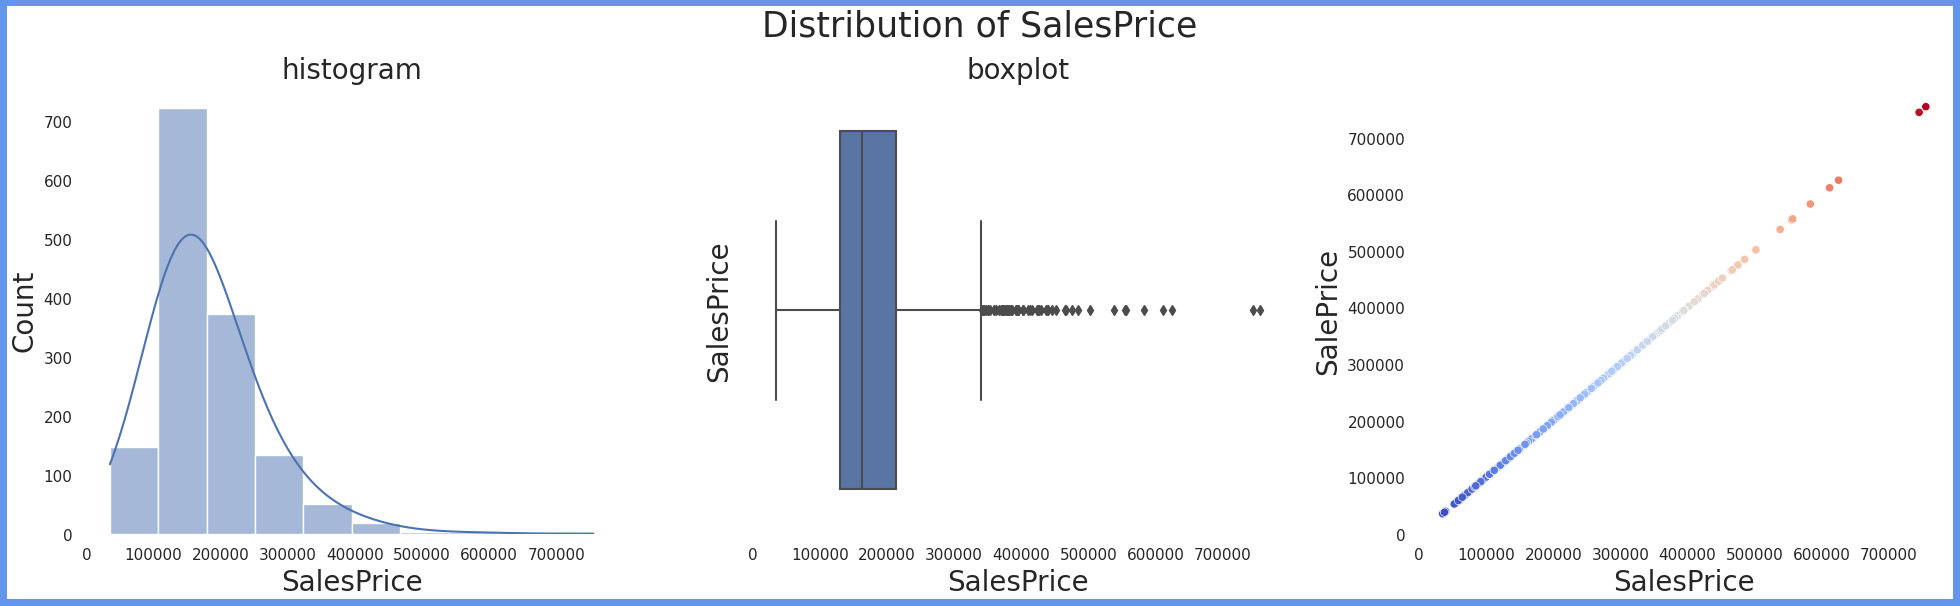

In [53]:
# Check distribution of target variable
univariate_numerical_plot(X_y,'SalesPrice')

As many features are available for plotting, we won't plot all of them. We can focus on features having higher correaltion (which is calculated in the section below).

## Correlation of X with y

In [54]:
def make_mi_scores(X, y):
    X = X.copy()
    # All discrete features should now have integer dtypes
    # discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X_train.select_dtypes('number'), y, random_state=0)
    mi_scores = pd.DataFrame(mi_scores.round(2), columns=["MI_Scores"], index=X.select_dtypes('number').columns)
    return mi_scores

In [55]:
mi_scores = make_mi_scores(X_train, y_train)
linear_corr = pd.DataFrame(X_train.corrwith(y_train).round(2), columns=['Lin_Correlation'])

corr_with_price = pd.concat([mi_scores, linear_corr], axis=1)
corr_with_price = corr_with_price.sort_values('MI_Scores',ascending=False)

corr_with_price

,MI_Scores,Lin_Correlation
Liv_Qual,0.73,0.82
TotalSF,0.68,0.78
OverallQual,0.57,0.79
MedNhbdArea,0.48,0.66
GrLivArea,0.48,0.71
BsmtArea_Qual,0.47,0.72
Bldg_1Fam,0.44,0.57
GarageArea_Qual,0.39,0.69
TotalBsmtSF,0.37,0.61
GarageArea,0.36,0.62


## Distribution of top 5 features correlated with Sales Price

In [56]:
top_features = corr_with_price.index[1:6]

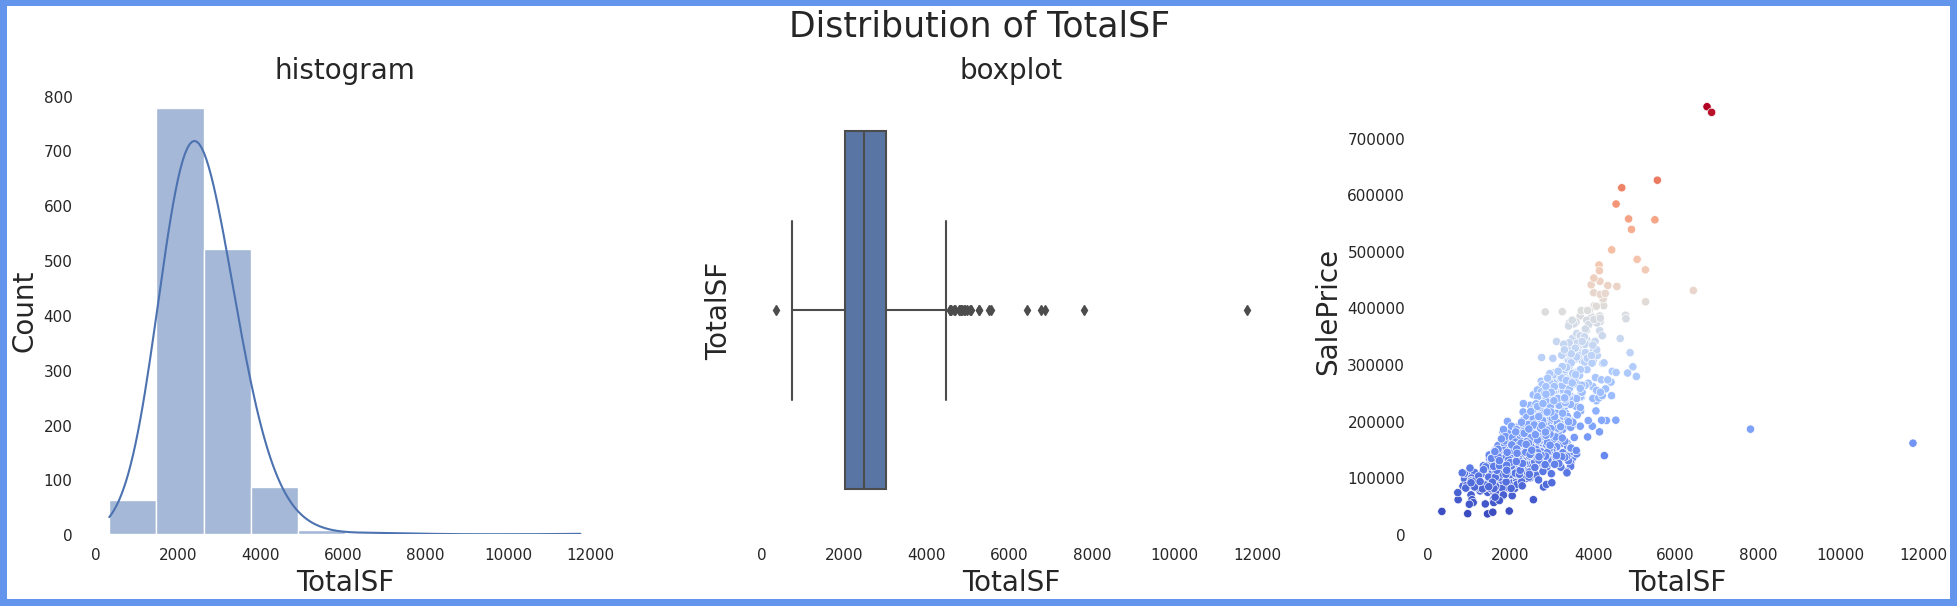

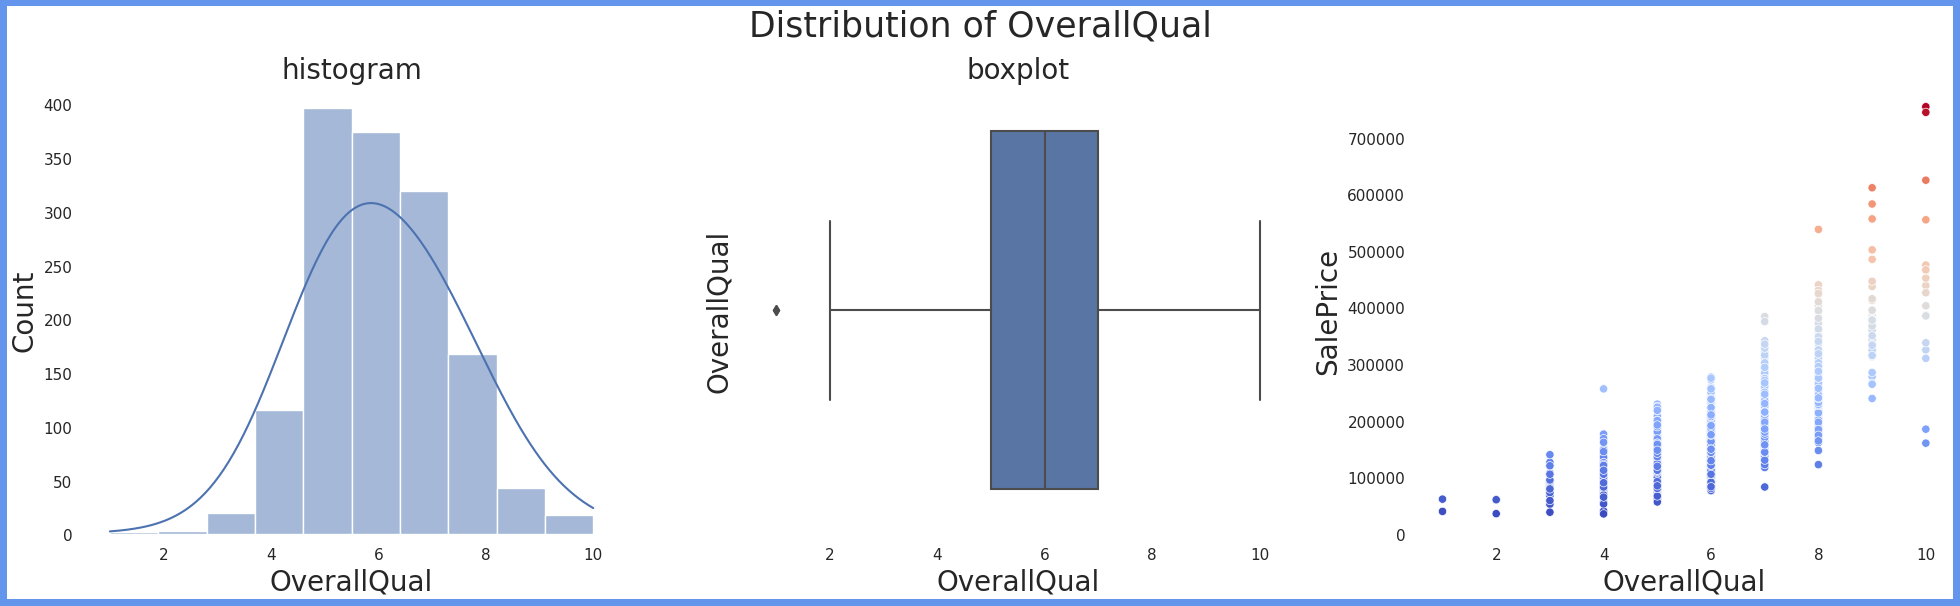

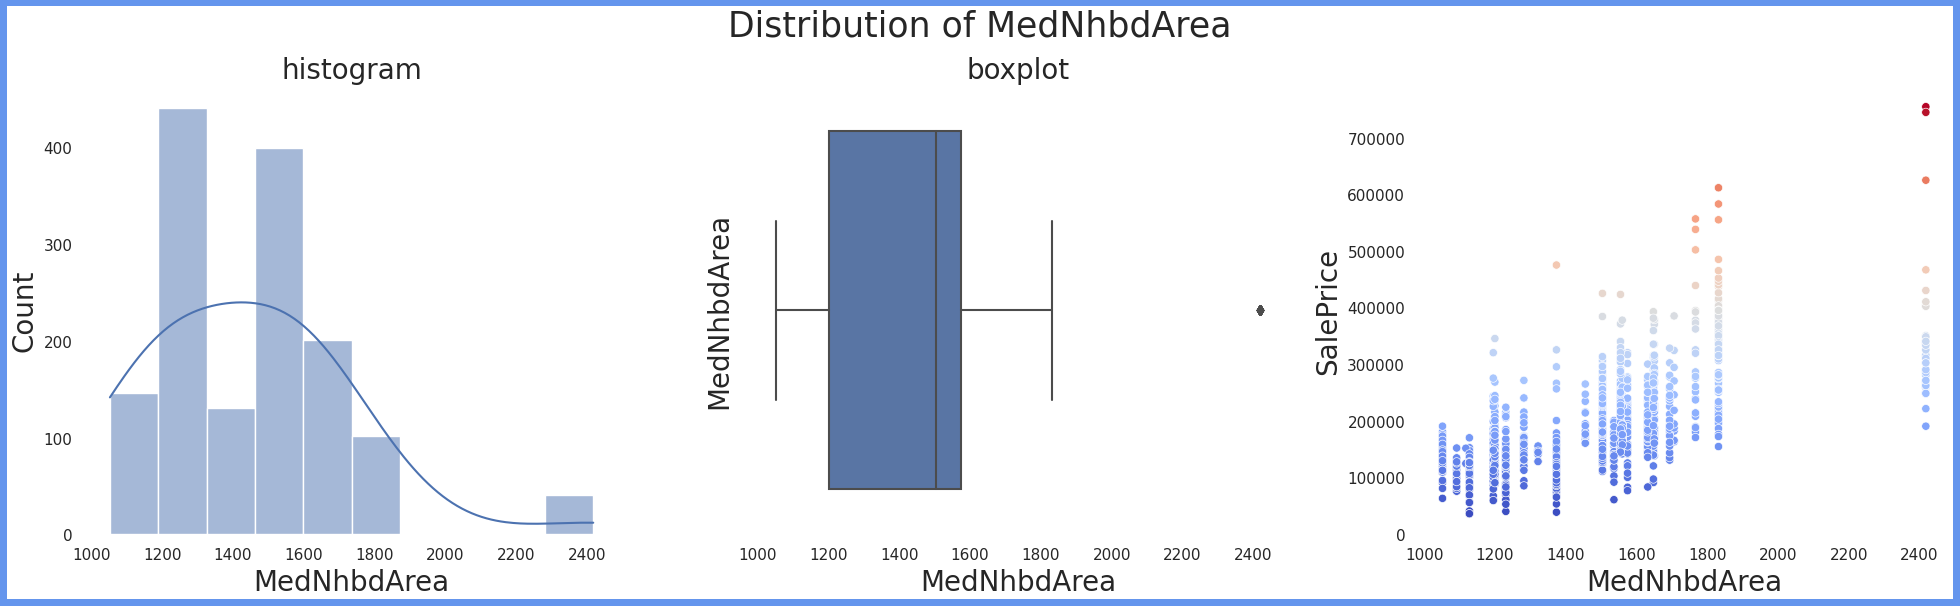

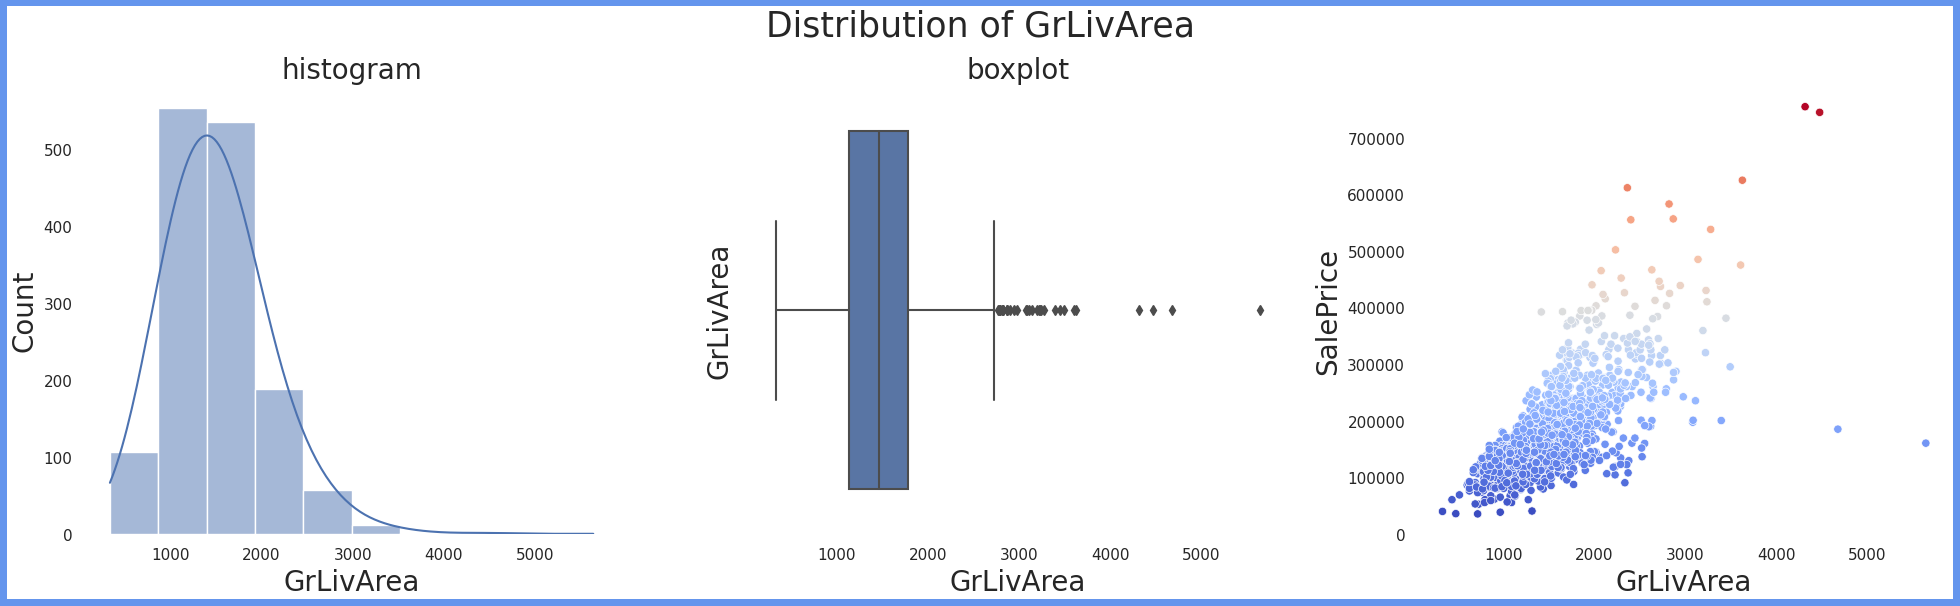

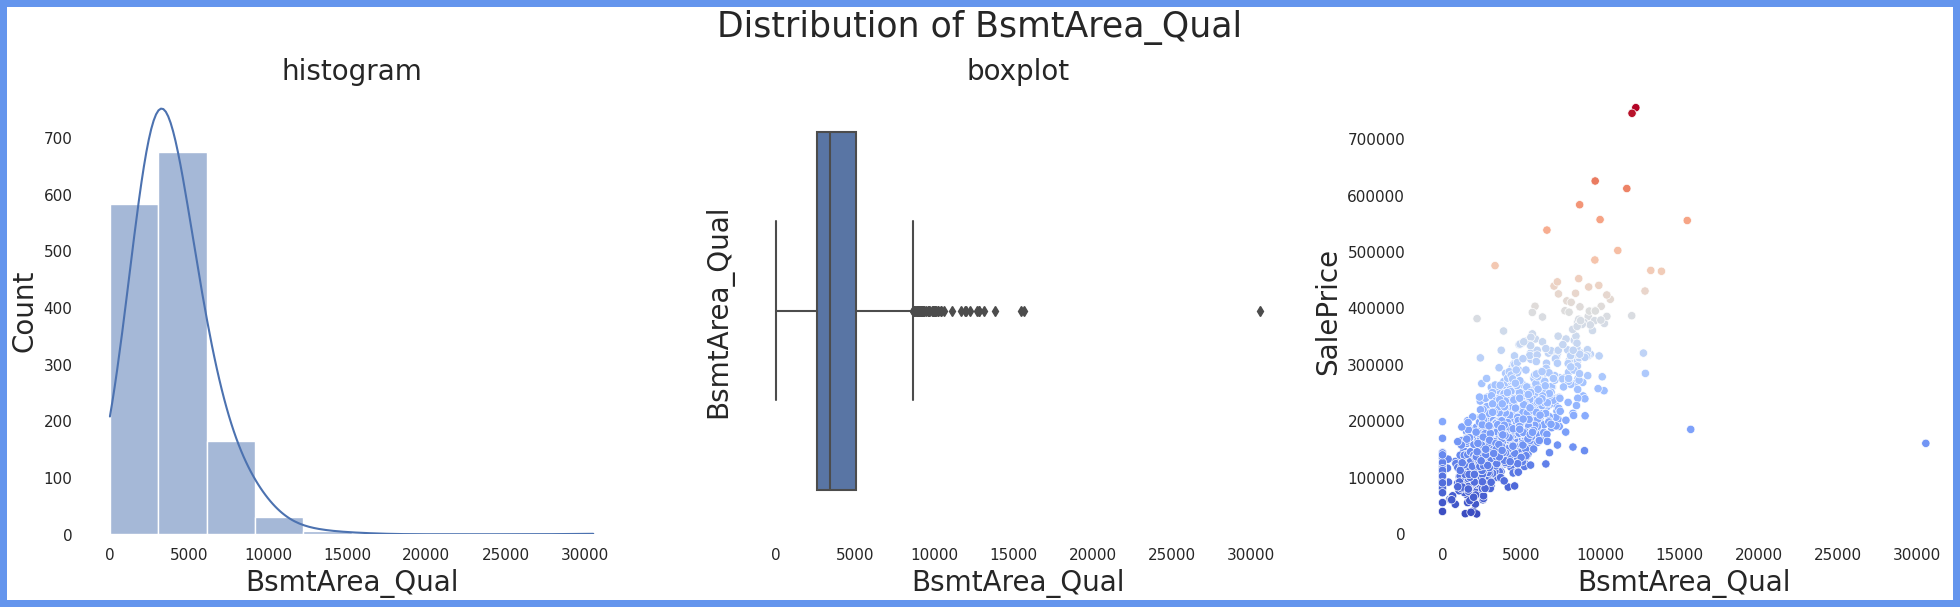

In [57]:
for feature in top_features:
    univariate_numerical_plot(X_train,feature)

# 5) Feature Selection<a id="Select"></a>

In [58]:
before = X_train.shape[1]
X_train.dtypes.value_counts()

float64    85
dtype: int64

In [59]:
# Numerical columns with large correlation with Sales Price
threshold = 0.01
numerical_cols = [cname for cname in X_train.select_dtypes('number').columns if corr_with_price.MI_Scores[cname] > threshold]

# Keep selected columns only
selected_cols = numerical_cols
X_train = X_train[selected_cols]
X_test = X_test[selected_cols]
after = X_train.shape[1]

# Selected Features for Model Training or Fitting
print(f'Out of {before} features, {after} features are having MI_Scores more than {threshold}.')

Out of 85 features, 67 features are having MI_Scores more than 0.01.


In [60]:
# To see which columns were selected according to min correlation condition
info = pd.DataFrame(X_train.dtypes, columns=['Dtype'])
info['Unique'] = X_train.nunique().values
info['Null'] = X_train.isnull().sum().values
info.sort_values(['Dtype', 'Unique'])

,Dtype,Unique,Null
Street,float64,2,0
CentralAir,float64,2,0
Garage,float64,2,0
Fireplace,float64,2,0
Bsmt,float64,2,0
RoofStyle,float64,3,0
BsmtHalfBath,float64,3,0
HalfBath,float64,3,0
PavedDrive,float64,3,0
MSZoning,float64,4,0


# 6) Model Creation<a id="Model"></a>

In [61]:
# Create object of class XGBRegressor
xgb = XGBRegressor(eval_metric='rmse')

## Grid Search & Cross Validation

In [62]:
param_grid = [
    {'subsample': [0.5], 'n_estimators': [1000,2000], 
     'max_depth': [3,6,12], 'learning_rate': [0.02],
     'colsample_bytree': [0.8], 'colsample_bylevel': [0.5],
     'reg_alpha':[1], 'reg_lambda': [1], 'min_child_weight':[2]}
]
grid_search = GridSearchCV(xgb, param_grid, cv=3, verbose=1, scoring='neg_root_mean_squared_error')

# 7) Training and Testing Model<a id="Test"></a>

In [63]:
%%time
grid_search.fit(X_train, np.log(y_train))
# Top 5 hyper-parameter combinations
cv_results = pd.DataFrame(grid_search.cv_results_)
display(cv_results.sort_values('rank_test_score')[:6])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_reg_alpha,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,2.302090,0.012685,0.014689,0.000362,0.5,0.8,0.02,3,2,2000,1,1,0.5,"{'colsample_bylevel': 0.5, 'colsample_bytree':...",-0.112552,-0.131273,-0.122927,-0.122251,0.007658,1
3,4.043727,0.611661,0.026645,0.000339,0.5,0.8,0.02,6,2,2000,1,1,0.5,"{'colsample_bylevel': 0.5, 'colsample_bytree':...",-0.113723,-0.130952,-0.122595,-0.122424,0.007035,2
2,2.200769,0.589726,0.015314,0.000438,0.5,0.8,0.02,6,2,1000,1,1,0.5,"{'colsample_bylevel': 0.5, 'colsample_bytree':...",-0.113900,-0.131298,-0.123157,-0.122785,0.007108,3
5,11.444480,5.373157,0.056090,0.029711,0.5,0.8,0.02,12,2,2000,1,1,0.5,"{'colsample_bylevel': 0.5, 'colsample_bytree':...",-0.114271,-0.131336,-0.123077,-0.122894,0.006968,4
4,2.911445,0.573036,0.020022,0.000365,0.5,0.8,0.02,12,2,1000,1,1,0.5,"{'colsample_bylevel': 0.5, 'colsample_bytree':...",-0.114608,-0.131512,-0.123369,-0.123163,0.006903,5
0,7.771846,7.945094,0.016329,0.009688,0.5,0.8,0.02,3,2,1000,1,1,0.5,"{'colsample_bylevel': 0.5, 'colsample_bytree':...",-0.113310,-0.132572,-0.124028,-0.123303,0.007880,6


CPU times: user 2min 14s, sys: 1.82 s, total: 2min 16s
Wall time: 1min 35s


In [64]:
%%time
halv_search = HalvingGridSearchCV(xgb, param_grid, random_state=0, cv=3, verbose=1, scoring='neg_root_mean_squared_error')
halv_search.fit(X_train, np.log(y_train))
# Top 5 hyper-parameter combinations
cv_results = pd.DataFrame(halv_search.cv_results_)
display(cv_results.sort_values('rank_test_score')[:6])

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 486
max_resources_: 1460
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 486
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 1
n_candidates: 2
n_resources: 1458
Fitting 3 folds for each of 2 candidates, totalling 6 fits


,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_reg_alpha,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
7,1,1458,2.696475,0.605718,0.013951,0.000044,0.5,0.8,0.02,3,2,2000,1,1,0.5,"{'colsample_bylevel': 0.5, 'colsample_bytree':...",-0.113386,-0.131001,-0.121258,-0.121882,0.007205,1,-0.074892,-0.071355,-0.075051,-0.073766,0.001706
6,1,1458,1.115393,0.010359,0.010485,0.000082,0.5,0.8,0.02,3,2,1000,1,1,0.5,"{'colsample_bylevel': 0.5, 'colsample_bytree':...",-0.114335,-0.132264,-0.122496,-0.123032,0.007329,2,-0.087328,-0.082737,-0.087450,-0.085838,0.002193
1,0,486,1.193621,0.012733,0.008350,0.000185,0.5,0.8,0.02,3,2,2000,1,1,0.5,"{'colsample_bylevel': 0.5, 'colsample_bytree':...",-0.131536,-0.138894,-0.146910,-0.139113,0.006278,3,-0.072071,-0.072517,-0.078158,-0.074249,0.002770
0,0,486,0.609377,0.009112,0.006970,0.000554,0.5,0.8,0.02,3,2,1000,1,1,0.5,"{'colsample_bylevel': 0.5, 'colsample_bytree':...",-0.131502,-0.141006,-0.146219,-0.139576,0.006093,4,-0.082974,-0.082345,-0.090267,-0.085195,0.003596
3,0,486,1.442517,0.024683,0.011246,0.000237,0.5,0.8,0.02,6,2,2000,1,1,0.5,"{'colsample_bylevel': 0.5, 'colsample_bytree':...",-0.130300,-0.141744,-0.149243,-0.140429,0.007789,5,-0.061727,-0.063474,-0.065880,-0.063694,0.001703
2,0,486,1.183841,0.597249,0.009054,0.000748,0.5,0.8,0.02,6,2,1000,1,1,0.5,"{'colsample_bylevel': 0.5, 'colsample_bytree':...",-0.130042,-0.142884,-0.148376,-0.140434,0.007683,6,-0.072243,-0.072727,-0.076821,-0.073930,0.002053


CPU times: user 1min 7s, sys: 1.25 s, total: 1min 8s
Wall time: 37.2 s


In [65]:
%%time
randomized_search = RandomizedSearchCV(xgb, param_grid, random_state=0, cv=3, verbose=1, scoring='neg_root_mean_squared_error')
randomized_search.fit(X_train, np.log(y_train))
# Top 5 hyper-parameter combinations
cv_results = pd.DataFrame(randomized_search.cv_results_)
display(cv_results.sort_values('rank_test_score')[:6])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_colsample_bytree,param_colsample_bylevel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,2.280836,0.014115,0.017073,0.004046,0.5,1,1,2000,2,3,0.02,0.8,0.5,"{'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha...",-0.112552,-0.131273,-0.122927,-0.122251,0.007658,1
3,3.961505,0.603527,0.027363,0.000220,0.5,1,1,2000,2,6,0.02,0.8,0.5,"{'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha...",-0.113723,-0.130952,-0.122595,-0.122424,0.007035,2
2,2.597070,1.208753,0.015027,0.000311,0.5,1,1,1000,2,6,0.02,0.8,0.5,"{'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha...",-0.113900,-0.131298,-0.123157,-0.122785,0.007108,3
5,5.623501,0.817459,0.036470,0.001705,0.5,1,1,2000,2,12,0.02,0.8,0.5,"{'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha...",-0.114271,-0.131336,-0.123077,-0.122894,0.006968,4
4,2.959974,0.637879,0.019653,0.000379,0.5,1,1,1000,2,12,0.02,0.8,0.5,"{'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha...",-0.114608,-0.131512,-0.123369,-0.123163,0.006903,5
0,1.579860,0.567559,0.010593,0.000439,0.5,1,1,1000,2,3,0.02,0.8,0.5,"{'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha...",-0.113310,-0.132572,-0.124028,-0.123303,0.007880,6


CPU times: user 1min 49s, sys: 1.74 s, total: 1min 50s
Wall time: 1min 1s


In [66]:
%%time
halv_random_search = HalvingRandomSearchCV(xgb, param_grid, random_state=0, cv=3, verbose=1, scoring='neg_root_mean_squared_error')
halv_random_search.fit(X_train, np.log(y_train))
# Top 5 hyper-parameter combinations
cv_results = pd.DataFrame(halv_random_search.cv_results_)
display(cv_results.sort_values('rank_test_score')[:6])

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 5
min_resources_: 6
max_resources_: 1460
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 6
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=243. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 2
n_resources: 18
Fitting 3 folds for each of 2 candidates, totalling 6 fits


,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_colsample_bytree,param_colsample_bylevel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
6,1,18,1.070542,0.553575,0.004621,0.000702,0.5,1,1,2000,2,6,0.02,0.8,0.5,"{'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha...",-0.217376,-0.222951,-0.215321,-0.218549,0.003224,1,-0.230521,-0.226024,-0.238127,-0.231557,0.004995
7,1,18,0.638105,0.005756,0.004120,0.000100,0.5,1,1,2000,2,12,0.02,0.8,0.5,"{'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha...",-0.217376,-0.222951,-0.215321,-0.218549,0.003224,1,-0.230521,-0.226024,-0.238127,-0.231557,0.004995
1,0,6,0.640127,0.017846,0.004095,0.000280,0.5,1,1,2000,2,3,0.02,0.8,0.5,"{'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha...",-0.279252,-0.718480,-0.351588,-0.449773,0.192286,3,-0.403710,-0.401155,-0.425425,-0.410096,0.010889
3,0,6,0.657785,0.019037,0.003985,0.000123,0.5,1,1,2000,2,6,0.02,0.8,0.5,"{'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha...",-0.279252,-0.718480,-0.351588,-0.449773,0.192286,3,-0.403710,-0.401155,-0.425425,-0.410096,0.010889
5,0,6,0.649166,0.020823,0.003988,0.000154,0.5,1,1,2000,2,12,0.02,0.8,0.5,"{'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha...",-0.279252,-0.718480,-0.351588,-0.449773,0.192286,3,-0.403710,-0.401155,-0.425425,-0.410096,0.010889
0,0,6,0.328221,0.007886,0.005033,0.001125,0.5,1,1,1000,2,3,0.02,0.8,0.5,"{'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha...",-0.299830,-0.779258,-0.391967,-0.490352,0.207722,6,-0.459614,-0.457881,-0.450191,-0.455895,0.004095


CPU times: user 35.3 s, sys: 521 ms, total: 35.9 s
Wall time: 19.3 s


## Best Parameters:

In [67]:
grid_search.best_params_

{'colsample_bylevel': 0.5,
 'colsample_bytree': 0.8,
 'learning_rate': 0.02,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 2000,
 'reg_alpha': 1,
 'reg_lambda': 1,
 'subsample': 0.5}

In [68]:
halv_search.best_params_

{'colsample_bylevel': 0.5,
 'colsample_bytree': 0.8,
 'learning_rate': 0.02,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 2000,
 'reg_alpha': 1,
 'reg_lambda': 1,
 'subsample': 0.5}

In [69]:
randomized_search.best_params_

{'subsample': 0.5,
 'reg_lambda': 1,
 'reg_alpha': 1,
 'n_estimators': 2000,
 'min_child_weight': 2,
 'max_depth': 3,
 'learning_rate': 0.02,
 'colsample_bytree': 0.8,
 'colsample_bylevel': 0.5}

In [70]:
halv_random_search.best_params_

{'subsample': 0.5,
 'reg_lambda': 1,
 'reg_alpha': 1,
 'n_estimators': 2000,
 'min_child_weight': 2,
 'max_depth': 6,
 'learning_rate': 0.02,
 'colsample_bytree': 0.8,
 'colsample_bylevel': 0.5}

## Best score in grid search

**Public leader board will have little less RMSLE than that of on validation data**, because below error is on validation data when model is trained/fitted on 67% of the training data because of 3-fold cross validation.
Public leaderboard will have error on test data when model is retrained/refitted on 100% of the training data.

In [71]:
print("RMSLE on training data:",round(-grid_search.score(X_train, np.log(y_train)),4))
print("RMSLE on validation data:",round(-grid_search.best_score_,4))

RMSLE on training data: 0.0773
RMSLE on validation data: 0.1223


In [72]:
print("RMSLE on training data:",round(-halv_search.score(X_train, np.log(y_train)),4))
print("RMSLE on validation data:",round(-halv_search.best_score_,4))

RMSLE on training data: 0.0773
RMSLE on validation data: 0.1219


In [73]:
print("RMSLE on training data:",round(-randomized_search.score(X_train, np.log(y_train)),4))
print("RMSLE on validation data:",round(-randomized_search.best_score_,4))

RMSLE on training data: 0.0773
RMSLE on validation data: 0.1223


In [74]:
print("RMSLE on training data:",round(-halv_random_search.score(X_train, np.log(y_train)),4))
print("RMSLE on validation data:",round(-halv_random_search.best_score_,4))

RMSLE on training data: 0.0544
RMSLE on validation data: 0.2185


## To avoid overfitting:
Difference in the performance (Root Mean Squared Log Error) of model on training data and validation data should be minimized.

## Feature Importance

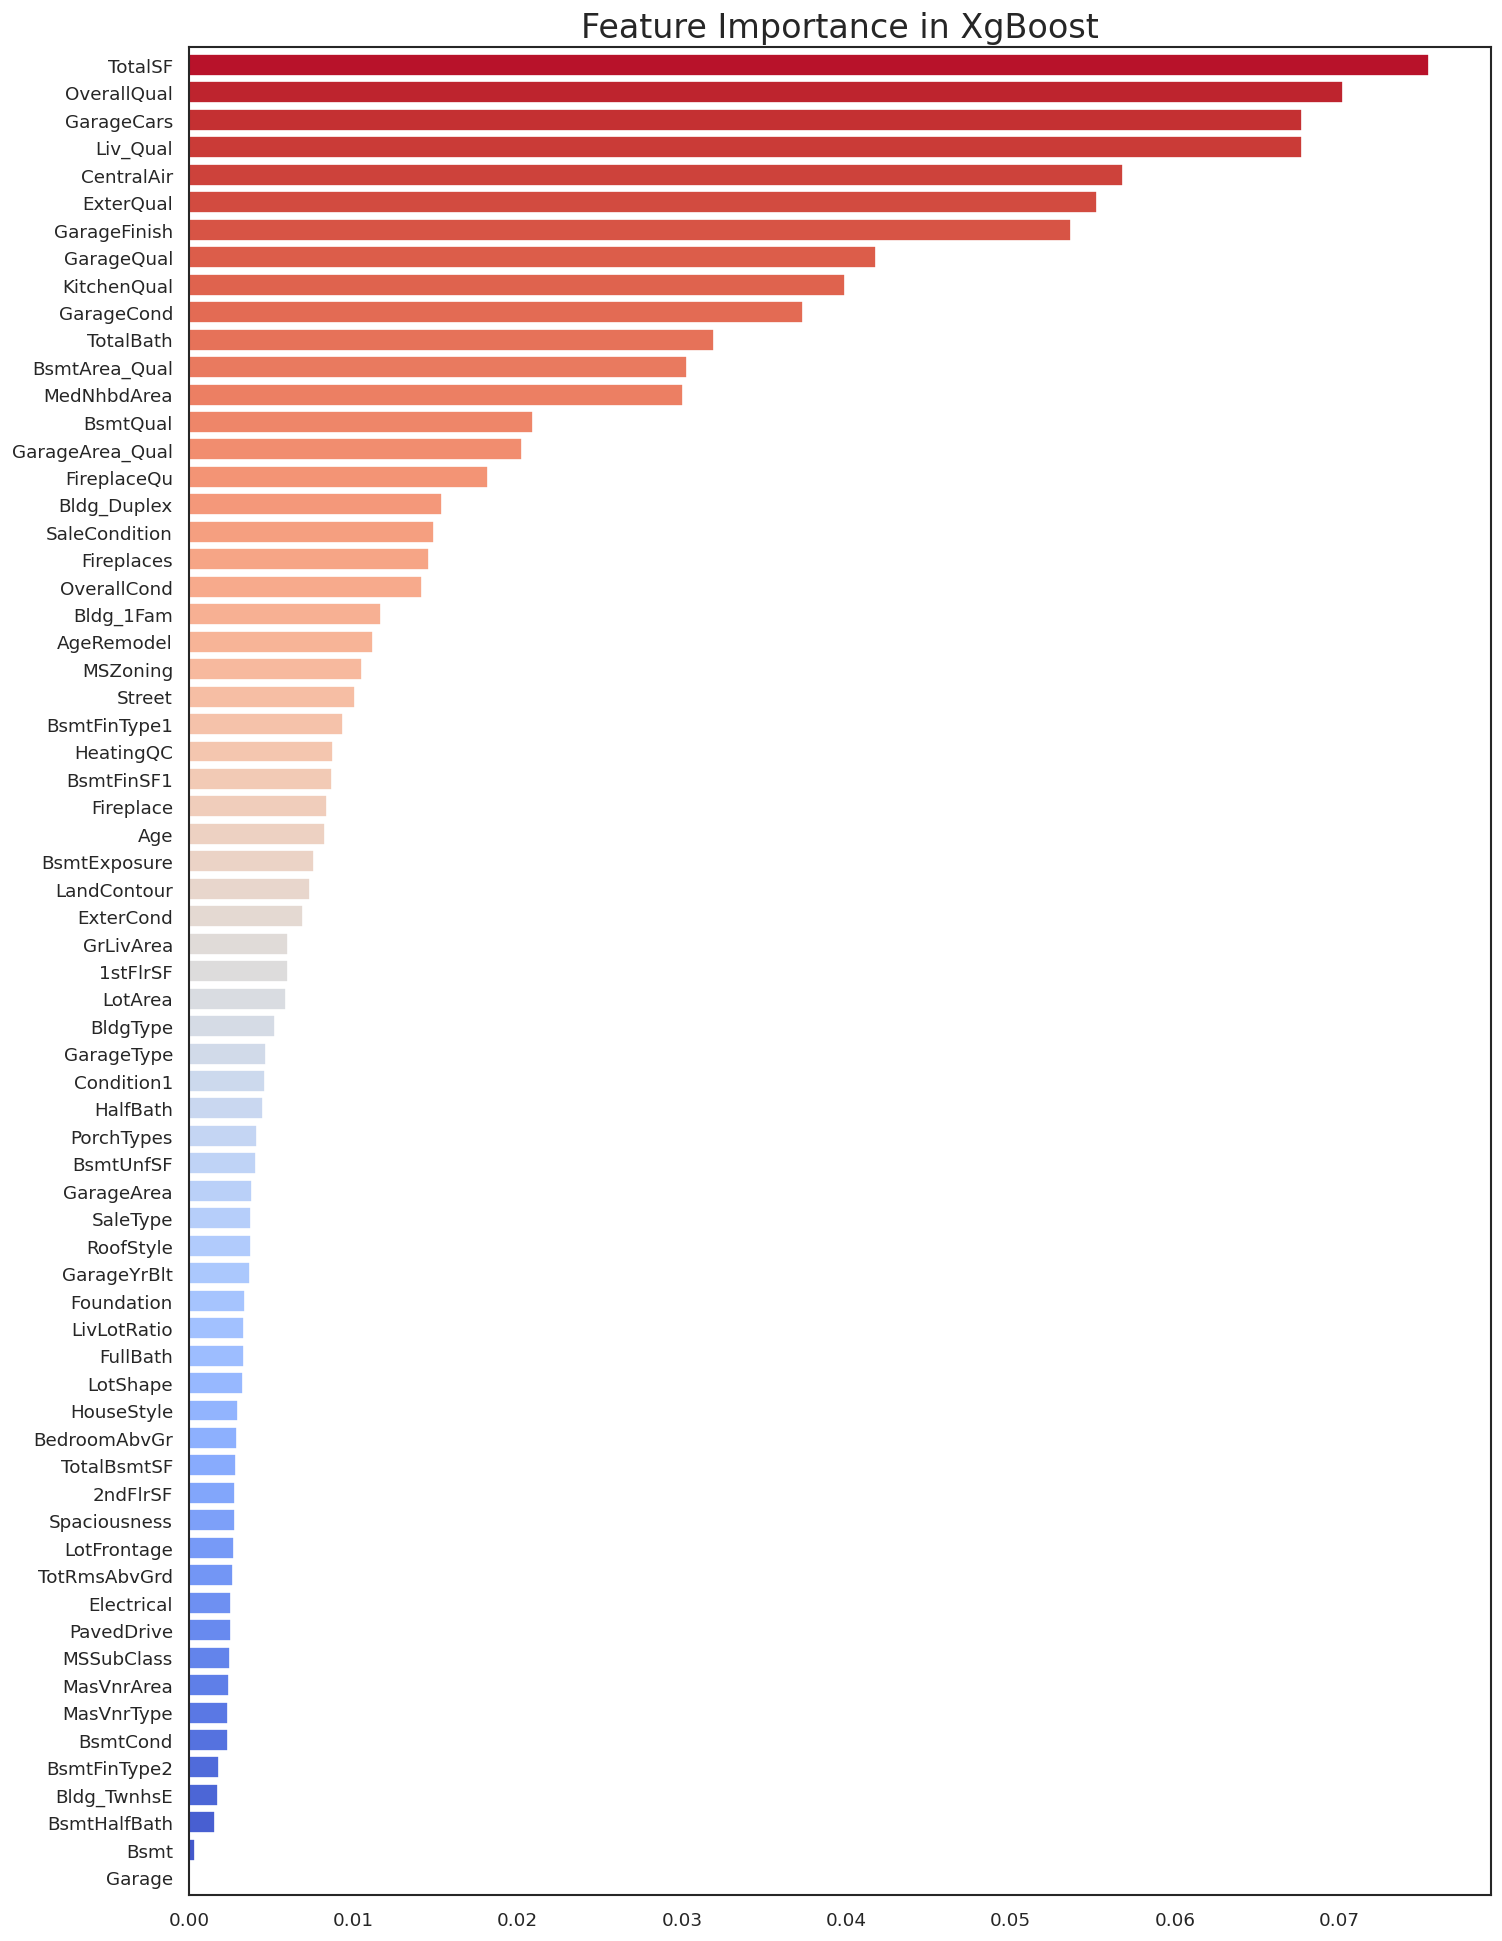

In [75]:
Feature_Imp = grid_search.best_estimator_.feature_importances_
Feature_Imp_sorted_series = pd.Series(Feature_Imp,X_train.columns).sort_values(ascending=True)

# Plot horizaontal bar plot
plt.figure(figsize=(14,20), dpi=120)
palette = sns.color_palette("coolwarm", len(X_train.columns)).as_hex()
ax = Feature_Imp_sorted_series.plot.barh(width=0.8 ,color=palette)
ax.set_title('Feature Importance in XgBoost')
plt.show()

## Generate test predictions

array([[<Axes: title={'center': '0'}>]], dtype=object)

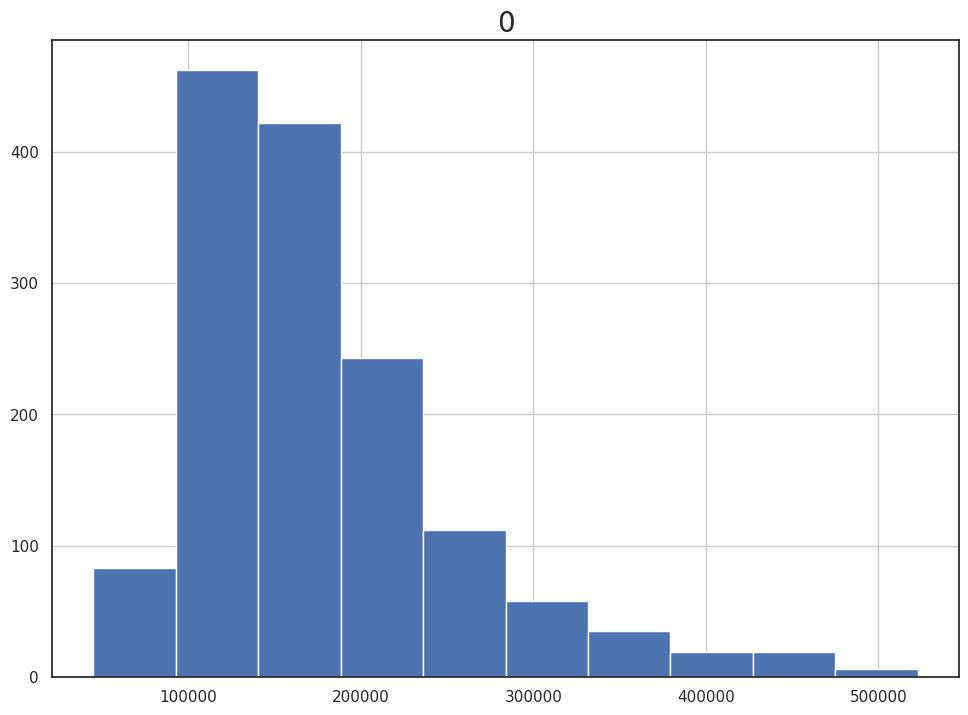

In [76]:
y_preds = np.exp(grid_search.predict(X_test))
pd.DataFrame(y_preds).hist()